In [1]:
import pandas as pd
import numpy as np
import datetime
import random
from scipy import spatial
import math
import json
import copy as cp
from matplotlib import pyplot
import re

#for regression
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

%matplotlib inline

from pymongo import MongoClient
mdbClient = MongoClient('localhost',27017)

In [2]:
t0 = datetime.datetime.now()

In [3]:
# Getting Data from Klachaks
srcData = pd.read_csv("C:\Home\Work\GreatLakes\capstone\withOldData\LatestDataFromKlachaks.csv")

In [4]:
srcData.head()

,Cust_Id,Customer_Name,Order_Status,Rentals,RentalsPaid,Start,End,QID,IID,ProductID,ProductName
0,NaN,ganesh,closed,4200.0,4200.0,2012-11-14 00:00:00,2012-11-17 00:00:00,1,4,4,Canon EOS 5D Mark II
1,NaN,ganesh,complete,900.0,900.0,2013-01-09 09:00:00,2013-01-10 09:00:00,11,11,48,Nikon D7000
2,NaN,ganesh,complete,1800.0,1800.0,2013-01-09 09:00:00,2013-01-10 09:00:00,15,13,48,Nikon D7000
3,NaN,ganesh,complete,1800.0,1800.0,2013-01-09 09:00:00,2013-01-10 09:00:00,15,15,48,Nikon D7000
4,NaN,ganesh,complete,2600.0,2600.0,2013-01-10 09:00:00,2013-01-11 09:00:00,17,17,48,Nikon D7000


In [5]:
#formatting it for CF, what we need is only Customer Name and Product
srcData.head()

WorkingData = cp.deepcopy(srcData)

WorkingData = WorkingData.loc[:,['Customer_Name','ProductName']]

WorkingData['count'] = 1

WorkingData.columns = ['customer','product','count']

t1 = datetime.datetime.now()
for prd in range(len(WorkingData)):
    WorkingData.iloc[prd,1] = re.sub('[^A-Za-z0-9]+',' ',WorkingData.iloc[prd,1])
print(datetime.datetime.now() - t1)

item_user_df = cp.deepcopy(WorkingData)

0:02:03.162631


In [252]:
#RFM Score
RFM_Score = pd.read_csv("RFM_Score_.csv")

In [253]:
RFM_Score.head()

,Name,RecencyIndex,FreeqIndex,monitoryIndx,RFM
0,PARTHIBAN,2,1,2,212
1,A,1,3,3,133
2,A J Aravind,2,1,1,211
3,A P S,3,1,2,312
4,A.G,3,1,2,312


In [6]:


t1 = datetime.datetime.now()
# Assign the Rating Based on    of time user has purchased that product
item_user_count = item_user_df.groupby(['customer','product']).aggregate(sum)
item_user_count = item_user_count.reset_index()
item_user_ratings = item_user_count
item_user_ratings['Ratings']=np.nan


#Randomly Assign the ratings
ratingScale = np.array([1,2,3,4,5])
for idx in item_user_ratings.index:
    item_user_ratings.iloc[idx,3] = np.random.choice(ratingScale,1, p=[0.4,0.45,0.1,0.05,0.0])[0] if item_user_ratings.iloc[idx,2] ==1 else (np.random.choice(ratingScale,1, p=[0.05,0.2,0.4,0.3,0.05])[0] if item_user_ratings.iloc[0,2] == 2 else np.random.choice(ratingScale,1, p=[0.0,0.15,0.35,0.35,0.15])[0])

print(datetime.datetime.now() - t1)



0:00:22.270132


In [7]:

# Centering the Rating
t1 = datetime.datetime.now()
AverageRating = item_user_ratings.loc[:,['product','Ratings']].groupby('product').mean()
AverageRating = AverageRating.reset_index()
item_user_ratings = pd.merge(item_user_ratings,AverageRating, on='product', how='left')
item_user_ratings.columns = ['customer','product','count','OriginalRatings','AverageRatings']
item_user_ratings['CenteredRatings'] = item_user_ratings.loc[:,'OriginalRatings'] - item_user_ratings.loc[:,'AverageRatings']
item_user_ratings['OriginalRatings'] = item_user_ratings['OriginalRatings'].astype('Int64')
print(datetime.datetime.now() - t1)



0:00:00.034055


In [76]:
len(item_user_ratings)

12982

In [15]:
TestArray = np.random.choice(range(round(len(item_user_ratings)*.6)),round(len(item_user_ratings)*.6),replace=False)

In [16]:
item_user_ratings_t = cp.deepcopy(item_user_ratings)

In [17]:
item_user_ratings_t = item_user_ratings_t.iloc[TestArray,:]

In [18]:
item_user_ratings_t.shape

(7789, 6)

In [19]:
# TO AVOID DIVISION BY ZERO ERROR, WE WILL REPLACE CenteredRatings 0 WITH 0.0001
item_user_ratings.loc[item_user_ratings.loc[:,'CenteredRatings']==0,'CenteredRatings'] = 0.0001

In [20]:

# Create Item User Matrix with original rating and to be predircted ratings [this is used for measuring similarity]
t1 = datetime.datetime.now()
unique_products = np.unique(item_user_ratings['product'])
unique_customers = np.unique(item_user_ratings['customer'])
s_user_item_matrix = pd.DataFrame(0, columns=unique_customers, index=unique_products)
o_user_item_matrix = pd.DataFrame(0, columns=unique_customers, index=unique_products)
p_user_item_matrix = pd.DataFrame(0, columns=unique_customers, index=unique_products)

#Test Set
t_user_item_matrix = pd.DataFrame(0, columns=unique_customers, index=unique_products)

for c in unique_customers:
    s_user_item_matrix.loc[item_user_ratings.loc[item_user_ratings.loc[:,'customer'] == c,'product'],c] = np.array(item_user_ratings.loc[item_user_ratings.loc[:,'customer'] == c,'OriginalRatings'])
    o_user_item_matrix.loc[item_user_ratings.loc[item_user_ratings.loc[:,'customer'] == c,'product'],c] = np.array(item_user_ratings.loc[item_user_ratings.loc[:,'customer'] == c,'OriginalRatings'])
    p_user_item_matrix.loc[item_user_ratings.loc[item_user_ratings.loc[:,'customer'] == c,'product'],c] = np.array(item_user_ratings.loc[item_user_ratings.loc[:,'customer'] == c,'CenteredRatings'])
    #Test Set
    t_user_item_matrix.loc[item_user_ratings_t.loc[item_user_ratings_t.loc[:,'customer'] == c,'product'],c] = np.array(item_user_ratings_t.loc[item_user_ratings_t.loc[:,'customer'] == c,'OriginalRatings'])
print(datetime.datetime.now() - t1) 


0:02:14.965256


In [21]:
t_user_item_matrix

,PARTHIBAN,A,A J Aravind,A P S,A.G,A.R,A.R.Naazar,A.X.P Leo,ABDUL,ABIN,...,vivek,vivekan,vrinda binani,vyasaraj,williams,yash,yeshwanthraj,yogesh,yuvaraj,சிவபெருமாள்
3 feet Slider,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
4 feet Slider,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5 in 1 Reflector Disc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77mm Graduated ND Filter,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77mm Graduated blue Color Filter,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aperture DSLR Shoulder Rig V2,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Apurture 7 inch HD SCreen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arm for GoPro,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ArriSun 1 2K HMI Par Kit,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Azden WLX PRO VHF Wireless Microphone System,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Sparcity Level
#Overall Rating Sparicity
ratedCount = np.count_nonzero(s_user_item_matrix)
matrixSize = s_user_item_matrix.shape[0]*s_user_item_matrix.shape[1]
sparcePercentage = (ratedCount/matrixSize)*100

sparcityDF = pd.DataFrame()

#Item wise rating Sparcity and Variance from Overall Sparcity.
TotalUsers = len(unique_customers)
for prd in unique_products:
    sparcityDF = sparcityDF.append({'product':prd, 'Sparcity':(np.count_nonzero(s_user_item_matrix.loc[prd,:])/TotalUsers)*100}, ignore_index=True)


# % of products that are lesser than Overall Sparcity
(len(sparcityDF.loc[sparcityDF.loc[:,'Sparcity']<sparcePercentage,:])/len(unique_products))*100



64.77272727272727

In [23]:
# Sparcity Level
#Overall Rating Sparicity for Test data
ratedCount = np.count_nonzero(t_user_item_matrix)
matrixSize = t_user_item_matrix.shape[0]*t_user_item_matrix.shape[1]
sparcePercentage = (ratedCount/matrixSize)*100

sparcityDF = pd.DataFrame()

#Item wise rating Sparcity and Variance from Overall Sparcity.
TotalUsers = len(unique_customers)
for prd in unique_products:
    sparcityDF = sparcityDF.append({'product':prd, 'Sparcity':(np.count_nonzero(s_user_item_matrix.loc[prd,:])/TotalUsers)*100}, ignore_index=True)


# % of products that are lesser than Overall Sparcity
(len(sparcityDF.loc[sparcityDF.loc[:,'Sparcity']<sparcePercentage,:])/len(unique_products))*100

53.97727272727273

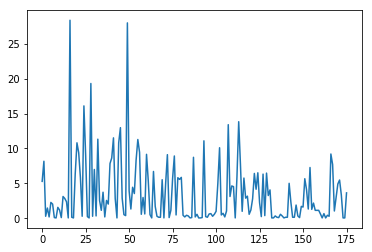

In [26]:
pyplot.plot(range(len(sparcityDF)),sparcityDF.Sparcity)

{'boxes': [<matplotlib.lines.Line2D at 0x1ab1d169fd0>],
 'caps': [<matplotlib.lines.Line2D at 0x1ab1d17d9e8>,
 'fliers': [<matplotlib.lines.Line2D at 0x1ab1d183c18>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1ab1d183400>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1ab1d175978>,
  <matplotlib.lines.Line2D at 0x1ab1d175b70>]}

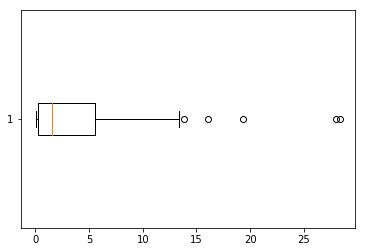

In [27]:
pyplot.boxplot(sparcityDF.Sparcity, vert=False)

In [28]:
#Calculating Cosine Similarity Index using p_user_itemMatrix
t1 = datetime.datetime.now()
item_item_matrix = pd.DataFrame(np.nan, columns=unique_products, index=unique_products)

for prd1 in unique_products:
    vec1 = p_user_item_matrix.loc[prd1,:]
    for prd2 in unique_products:
        vec2 = p_user_item_matrix.loc[prd2,:]
        item_item_matrix.loc[prd1,prd2] = 1-spatial.distance.cosine(vec1,vec2)
print(datetime.datetime.now() - t1)        



0:00:39.266968


In [29]:
#Rating Prediction
def FindNeighborAndRelativeWeight(user,item,items,n):
    # This will return all the Similar Items that are rated related to the Selected item, 'item'
    ItemSimilarities = pd.DataFrame(item_item_matrix.loc[items,item])
    ItemSimilarities = ItemSimilarities.reset_index()
    ItemSimilarities.columns = ['product_c','similarity']
    # We will sort the item decending to have the most similar item first
    ItemSimilarities = ItemSimilarities.sort_values('similarity',ascending=False)
    # Based on the Number of similar neigbors (n), we can select those.
    ItemSimilarities = ItemSimilarities.head(n)
                                  
    # We have totake the rating of Most similar product. To do that, we have to take the product id of most similar product and pass it back
    # pass it basck to user item matrix to get the rating. Mind that the order has to be same.
    # Otherwise sum product will go wrong
    SimilarProducts = np.array(ItemSimilarities.loc[:,'product_c'])
    
    #Identify Similarity Score and Original Rating
    SimilarityScore = np.array(ItemSimilarities.loc[:,'similarity'])
    OriginalRating = np.array(o_user_item_matrix.loc[SimilarProducts,user])
    
    #Predict the Score using Weighted Average
    SumSimilarities = sum(SimilarityScore) if sum(SimilarityScore) != 0 else .0001
    p_rating = np.dot(SimilarityScore,OriginalRating)/SumSimilarities
    
    #o_user_item_matrix.loc[:,113]
    return(math.ceil(p_rating))
    #return(np.sort(item_item_matrix.loc[items,item],axis=-1,kind='quicksort')[::-1][:k])
    

In [31]:
#Rating Prediction
def FindNeighborAndRelativeWeight_t(user,item,items,n):
    # This will return all the Similar Items that are rated related to the Selected item, 'item'
    ItemSimilarities = pd.DataFrame(item_item_matrix.loc[items,item])
    ItemSimilarities = ItemSimilarities.reset_index()
    ItemSimilarities.columns = ['product_c','similarity']
    # We will sort the item decending to have the most similar item first
    ItemSimilarities = ItemSimilarities.sort_values('similarity',ascending=False)
    # Based on the Number of similar neigbors (n), we can select those.
    ItemSimilarities = ItemSimilarities.head(n)
                                  
    # We have totake the rating of Most similar product. To do that, we have to take the product id of most similar product and pass it back
    # pass it basck to user item matrix to get the rating. Mind that the order has to be same.
    # Otherwise sum product will go wrong
    SimilarProducts = np.array(ItemSimilarities.loc[:,'product_c'])
    
    #Identify Similarity Score and Original Rating
    SimilarityScore = np.array(ItemSimilarities.loc[:,'similarity'])
    OriginalRating = np.array(t_user_item_matrix.loc[SimilarProducts,user])
    
    #Predict the Score using Weighted Average
    SumSimilarities = sum(SimilarityScore) if sum(SimilarityScore) != 0 else .0001
    p_rating = np.dot(SimilarityScore,OriginalRating)/SumSimilarities
    
    #o_user_item_matrix.loc[:,113]
    return(math.ceil(p_rating))
    #return(np.sort(item_item_matrix.loc[items,item],axis=-1,kind='quicksort')[::-1][:k])

In [30]:
t1 = datetime.datetime.now()
# k - will hol dthe index keys for nonzero rating of the iser 'user'
# O_U_I_U_R_I = Original User Item User Rated Item - Will hold the User rated Item' Ids
for item in o_user_item_matrix.index:
    for user in o_user_item_matrix.columns:
        if o_user_item_matrix.loc[item,user] == 0:
            k = np.nonzero(o_user_item_matrix.loc[:,user])
            O_U_I_U_R_I = o_user_item_matrix.index[k]
            o_user_item_matrix.loc[item,user] = FindNeighborAndRelativeWeight(user,item,O_U_I_U_R_I,2)
            

print(datetime.datetime.now() - t1)


0:56:23.234269


In [38]:
### Model Evaluation
t1 = datetime.datetime.now()
# k_t - will hol dthe index keys for nonzero rating of the iser 'user'
# O_U_I_U_R_I = Original User Item User Rated Item - Will hold the User rated Item' Ids
for item_t in t_user_item_matrix.index:
    for user_t in t_user_item_matrix.columns:
        if t_user_item_matrix.loc[item_t,user_t] == 0:
            k_t = np.nonzero(t_user_item_matrix.loc[:,user_t])
            O_U_I_U_R_I_t = t_user_item_matrix.index[k_t]
            t_user_item_matrix.loc[item_t,user_t] = FindNeighborAndRelativeWeight_t(user_t,item_t,O_U_I_U_R_I_t,2)
            

print(datetime.datetime.now() - t1)

0:55:44.278248


In [39]:
item_user_rating_complete = pd.DataFrame()

In [40]:
item_user_rating_temp = pd.DataFrame()
item_user_rating_temp_test = pd.DataFrame()

In [41]:
custName = unique_customers

In [42]:
t1 = datetime.datetime.now()
for prod in unique_products:
    predRating = list(o_user_item_matrix.loc[prod,:])
    srcRating = list(s_user_item_matrix.loc[prod,:])
    t_Rating = list(t_user_item_matrix.loc[prod,:])
    temp_df = pd.DataFrame({'customer': custName,'product':prod,'PrediectedRating': predRating,'SourceRating':srcRating} )
    temp_df_t = pd.DataFrame({'customer': custName,'product':prod,'PrediectedRating': predRating,'SourceRating':srcRating, 'TestRating': t_Rating} )
    item_user_rating_temp = item_user_rating_temp.append(temp_df)
    item_user_rating_temp_test = item_user_rating_temp.append(temp_df_t)
print(datetime.datetime.now() - t1)

0:00:09.212128


In [45]:
item_user_rating_temp_test.to_csv("TestRults.csv")

In [46]:
item_user_rating_complete = item_user_rating_temp

In [47]:
item_user_rating_complete['predicted'] = 'Y' 

In [48]:
item_user_rating_complete.loc[item_user_rating_complete.loc[:,'SourceRating']!=0,'predicted'] = 'N'

In [49]:
item_user_rating_complete = item_user_rating_complete.loc[:,['customer','product','PrediectedRating','predicted']]

In [50]:
item_user_rating_complete.columns = ['customer', 'product', 'rating', 'predicted']

In [51]:
len(item_user_rating_complete)

372768

In [52]:
#Evaluation
item_user_rating_eval = cp.deepcopy(item_user_rating_temp_test)

In [53]:
item_user_rating_eval['predicted'] = 'Y'

In [54]:
item_user_rating_eval.loc[item_user_rating_eval.loc[:,'SourceRating']!=0,'predicted'] = 'N'

In [60]:
item_user_rating_eval = item_user_rating_eval.loc[item_user_rating_eval.loc[:,'TestRating'] >= 0,:]

In [66]:
 item_user_rating_eval = item_user_rating_eval.loc[item_user_rating_eval.loc[:,'predicted'] == 'Y',:]

In [74]:
item_user_rating_eval.loc[item_user_rating_eval.loc[:,'SourceRating'] > 0,:]

,PrediectedRating,SourceRating,TestRating,customer,product,predicted


In [73]:
np.sqrt(sum(((item_user_rating_eval.SourceRating - item_user_rating_eval.TestRating)**2)/len(item_user_rating_eval)))

2.2037338587354789

In [ ]:
item_user_rating_eval = item_user_rating_eval.loc[item_user_rating_eval.loc[:,'TestRating'] >= 0,:]

In [238]:
t1 = datetime.datetime.now()
u_ = range(len(o_user_item_matrix.columns))
p_ = range(len(o_user_item_matrix.index))
## Insert Data to Mongo DB
db = mdbClient.RE
for c in db.collection_names():
    db[c].drop()

In [239]:
col_item_user_rating = db.create_collection('item_user_rating')
col_item_item_matrix = db.create_collection('item_item_matrix')

In [256]:
sample = item_user_rating_complete

In [234]:
sample = sample.reset_index()

In [237]:
dict_item_user_rating_complete = sample.T.to_dict().values()
item_item_matrix_ = item_item_matrix.reset_index()
item_item_matrix_.columns = item_item_matrix_.columns.astype('str')
dict_item_item_matrix_complete = item_item_matrix_.T.to_dict().values()

In [240]:
col_item_user_rating.insert_many(dict_item_user_rating_complete)
col_item_item_matrix.insert_many(dict_item_item_matrix_complete)

In [218]:
print(datetime.datetime.now()-t0)

8:17:06.195502


In [260]:
item_user_rating_complete.head()

,customer,product,rating,predicted
0,PARTHIBAN,3 feet Slider,1,Y
1,A,3 feet Slider,1,Y
2,A J Aravind,3 feet Slider,3,Y
3,A P S,3 feet Slider,1,Y
4,A.G,3 feet Slider,1,Y


In [ ]:
#Evaluating using Liner Regression

